# Final Assignment: Predicting Hurricane speed movements with Machine Learning Methods

In [1]:
#importing all the modules
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import box
from shapely.geometry import Point
import haversine as hs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

Using TensorFlow backend.


## 1. Exploratory Data Analysis & Data Cleaning

In this first section, the data will be imported, cleaned, formatted and explored in order to start approaching the subsequent prediction problem. It is very important here to get a full understanding of the data structure, quality and content. In this case, a historical dataset regarding hurricanes in the atlantic will be the analysed one. 

In [2]:
#Read the atlantic dataset
data = pd.read_csv('data/atlantic.csv')

In [3]:
#display first 5 rows and last 5 rows of the dataset
data

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,18510625,0,,HU,28.0N,94.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,18510625,600,,HU,28.0N,95.4W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,18510625,1200,,HU,28.0N,96.0W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,18510625,1800,,HU,28.1N,96.5W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,18510625,2100,L,HU,28.2N,96.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49100,AL122015,KATE,20151112,1200,,EX,41.3N,50.4W,55,981,...,180,120,120,120,60,0,0,0,0,0
49101,AL122015,KATE,20151112,1800,,EX,41.9N,49.9W,55,983,...,180,120,120,120,60,0,0,0,0,0
49102,AL122015,KATE,20151113,0,,EX,41.5N,49.2W,50,985,...,200,220,120,120,60,0,0,0,0,0
49103,AL122015,KATE,20151113,600,,EX,40.8N,47.5W,45,985,...,180,220,0,0,0,0,0,0,0,0


In [4]:
#check the data shape & temporal length
data.shape

(49105, 22)

The dataset is composed by 49105 rows (records) and 22 columns (attributes).

In [5]:
#check all data types of the dataset & its info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49105 entries, 0 to 49104
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                49105 non-null  object
 1   Name              49105 non-null  object
 2   Date              49105 non-null  int64 
 3   Time              49105 non-null  int64 
 4   Event             49105 non-null  object
 5   Status            49105 non-null  object
 6   Latitude          49105 non-null  object
 7   Longitude         49105 non-null  object
 8   Maximum Wind      49105 non-null  int64 
 9   Minimum Pressure  49105 non-null  int64 
 10  Low Wind NE       49105 non-null  int64 
 11  Low Wind SE       49105 non-null  int64 
 12  Low Wind SW       49105 non-null  int64 
 13  Low Wind NW       49105 non-null  int64 
 14  Moderate Wind NE  49105 non-null  int64 
 15  Moderate Wind SE  49105 non-null  int64 
 16  Moderate Wind SW  49105 non-null  int64 
 17  Moderate Win

With a very general notion of the data structure and types, it is time to start with the cleaning in order to be able to carry out the EDA and the subsequent predictive analysis. At first, duplicate and null values must be erased. Secondly, a reestructuration of the fields will be carred out (formatting, data types & structure). 

In [6]:
# Checking and eliminating duplicate values
duplicate_rows = data[data.duplicated()]
print("Duplicate rows : ", duplicate_rows.shape)

Duplicate rows :  (0, 22)


As shown in this previous output, there are no duplicate rows in our dataset (0 refers to rows and 22 refers to the number of attributes int the dataset). Subsequently, missing values will be checked and dropped.

In [7]:
#Checking and dropping missing values
print(data.isnull().sum())

ID                  0
Name                0
Date                0
Time                0
Event               0
Status              0
Latitude            0
Longitude           0
Maximum Wind        0
Minimum Pressure    0
Low Wind NE         0
Low Wind SE         0
Low Wind SW         0
Low Wind NW         0
Moderate Wind NE    0
Moderate Wind SE    0
Moderate Wind SW    0
Moderate Wind NW    0
High Wind NE        0
High Wind SE        0
High Wind SW        0
High Wind NW        0
dtype: int64


As also shown in this previous output, there are no null values on any of the dataset columns and records.



To continue with the data initial analysis, it is time to detect outliers in the data and delete its anomalies. Obviously, the outliers are only present in the continuous variables of the dataset. For this case, the main outliers to be detected will be in Longitude, Latitude, Max.Wind and Min.Pressure. Additionally, these must be reformatted: time and date (creating a timestamp column), lat and long will be normalized (only numerical and without the letter), and the rest of the wind values (low, moderate and high) will also be accordingly formatted.

#### Latitude and Longitude 
For these two attributes, first we must format the data as fully numerical, by taking out the N/S/E/W and adding a plus or a minus instead depending on its geographical location. Once this is done (new fields as normalized lat and normalized long), the outliers analysis can be carried out.

In [8]:
#Fixing latitude and longitude in order to be mapped

#arrays to store the mapping lat and long values which will be added to the dataset
map_long = []
map_lat = []

for i in data['Latitude']:
    if i.endswith('N'):
        new_lat_n = i.replace('N', '')
        lat_float_n = float(new_lat_n)
        map_lat.append(lat_float_n)
    else:
        #for the Southern hemisphere (which must be negative)
        new_lat_s = i.replace('S', '')
        lat_float_s = float(new_lat)
        lat_south = lat_float_s * -1 
        map_lat.append(lat_south)
        

#same procedure but for longitude
for i in data['Longitude']:
    if i.endswith('E'): #East is positive
        new_lon_e = i.replace('E', '')
        lon_float_e = float(new_lon_e)
        map_long.append(lon_float_e)
    else:
        #for the Western hemisphere (which must be negative)
        new_lon_w = i.replace('W', '')
        lon_float_w = float(new_lon_w)
        lat_west = lon_float_w * -1 
        map_long.append(lat_west)

In [9]:
#at the same time, the previous lat long attributes can be deleted
del data['Latitude']
del data['Longitude']

#We must append the two processed arrays to the Atlantic dataset
data['Lat'] = map_lat
data['Lon'] = map_long

In [10]:
data.head(5)

,ID,Name,Date,Time,Event,Status,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,...,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Lat,Lon
0,AL011851,UNNAMED,18510625,0,,HU,80,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,28.0,-94.8
1,AL011851,UNNAMED,18510625,600,,HU,80,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,28.0,-95.4
2,AL011851,UNNAMED,18510625,1200,,HU,80,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,28.0,-96.0
3,AL011851,UNNAMED,18510625,1800,,HU,80,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,28.1,-96.5
4,AL011851,UNNAMED,18510625,2100,L,HU,80,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,28.2,-96.8


Latitude max. value:  81.0
Latitude min. value:  7.2


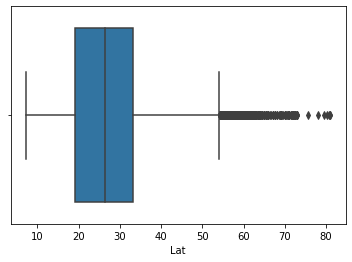

In [11]:
#Latitude outliers
lat_column = data['Lat']
sns.boxplot(x=lat_column)
print('Latitude max. value: ', lat_column.max())
print('Latitude min. value: ', lat_column.min())

As the latitude results show above, there are no anomal outliers on this attribute.

Longitude max. value:  63.0
Longitude min. value:  -359.1


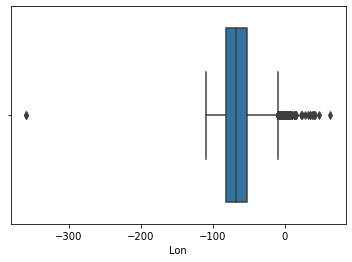

In [12]:
#Longitude outliers
long_column = data['Lon']
sns.boxplot(x= long_column)
print('Longitude max. value: ', long_column.max())
print('Longitude min. value: ', long_column.min())

As the longitude boxplot shows, there are a few points that are over -300. These are indeed anomal longitude values which have to be deleted from the dataset.

In [13]:
#Longitude anomal outliers
#Longitude values which are smaller than -300 as shown in the boxplot, are clear error values
anomal_long = data[(data['Lon'] < - 300)]
anomal_long

,ID,Name,Date,Time,Event,Status,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,...,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Lat,Lon
22984,AL051952,UNNAMED,19520914,600,,EX,35,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,43.2,-359.1
22985,AL051952,UNNAMED,19520914,1200,,EX,35,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,44.0,-358.4


In [14]:
#removal of the two anomal records
data = data[(data['Lon'] > - 300)]
data.shape

(49103, 22)

Finally, to conclude with the analysis and formatting of Latitude and Longitude, we must check the data on a map using the Geopandas library. For this, the KATE hurricane (as an example) will be selected (it would not make sense to display the whole dataset -> there would be too much data noise in the map).

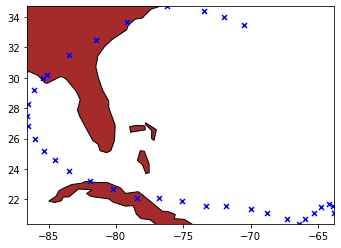

In [15]:
#creating geodataframe so data can be accordingly mapped
#selecting a random hurricane -> Hurricane Kate for example (the one that happened in 1985 in Florida)
kate = data[(data['Name'].str.contains("KATE")) & (data['Date'] < 19860000) ]
kate_gdf = gpd.GeoDataFrame(kate, geometry=gpd.points_from_xy(kate.Lon, kate.Lat))
#setting a projection 
proj_data = kate_gdf.set_crs(epsg=4326)
#adding a world basic basemap in the bounding box of the KATE hurricane
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='brown', edgecolor='black')
minx, miny, maxx, maxy = proj_data.total_bounds
base.set_xlim(minx, maxx)
base.set_ylim(miny, maxy)
proj_data.plot(ax=base, marker='x', color='blue', markersize=25);

This map does not have any purpose but verifying that the latitude and longitude fields have been accordingly cleaned, formatted and now are mappable. Therefore, as the map shows, the hurricane data is now well georeferrenced (hurricane Kate took place around Florida).

#### Max.Wind and Min.Pressure 

According to the metadata of this dataset (the dataset description), the missing values for Minimum Pressure are marked with -999 and the missing values for Maximum wind as -99. Therefore, we first identify these rows. 

In [16]:
anomal_maxwind = data[(data['Maximum Wind'] == -99)]
anomal_min_pressure = data[(data['Minimum Pressure'] == -999)]
print('Anomal Maximum Wind records: ', anomal_maxwind.shape)
print('Anomal Minimum Pressure records: ', anomal_min_pressure.shape)

Anomal Maximum Wind records:  (338, 22)
Anomal Minimum Pressure records:  (30667, 22)


According to these results, the Minimum Pressure column has so many missing records. However, it is a very important parameter for the subsequent prediction. According to this, the missing values (-999) will be marked as NaN and therefore no records are deleted.
Regarding the Maximum Wind, since there much less values missing, these will be replaced by the median values of the entire column. The median will be used since the wind is a countinuous phenomenon and its value should not be altered by any outlier.

In [17]:
#min pressure values formatting (-999 to NaN)
min_pressure = data['Minimum Pressure'].replace(-999, np.nan, regex=True)
#replace raw column by formatted column
del data['Minimum Pressure']
data = data.copy() #to handle SettingwithCopy warning
data['Minimum Pressure'] = min_pressure
data.head()

,ID,Name,Date,Time,Event,Status,Maximum Wind,Low Wind NE,Low Wind SE,Low Wind SW,...,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Lat,Lon,Minimum Pressure
0,AL011851,UNNAMED,18510625,0,,HU,80,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,28.0,-94.8,NaN
1,AL011851,UNNAMED,18510625,600,,HU,80,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,28.0,-95.4,NaN
2,AL011851,UNNAMED,18510625,1200,,HU,80,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,28.0,-96.0,NaN
3,AL011851,UNNAMED,18510625,1800,,HU,80,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,28.1,-96.5,NaN
4,AL011851,UNNAMED,18510625,2100,L,HU,80,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,28.2,-96.8,NaN


The new formatted Min.Pressure column has been added to the dataset, by deleting the raw one. It is placed at the end, like all the new columns. However, at the end of the data formatting the columns will be well reordered.

Maximum Wind max. value:  165.0
Maximum Wind min. value:  10.0


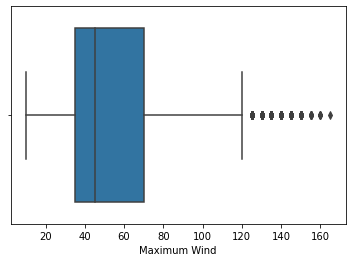

In [18]:
#max wind formatting -> calculating median and doing the replacement of missing values
max_wind_column = data['Maximum Wind']
median_max_wind = data['Maximum Wind'].median()
max_wind_column = max_wind_column.replace(to_replace=-99,value=median_max_wind)
del data['Maximum Wind']
data = data.copy() #to handle SettingwithCopy warning
data['Maximum Wind'] = max_wind_column

#Max wind outliers detection after replacing missing values with median
max_wind = data['Maximum Wind']
sns.boxplot(x= max_wind)
print('Maximum Wind max. value: ', max_wind.max())
print('Maximum Wind min. value: ', max_wind.min())

As shown right above, the smallest and the biggest records of this column make now sense. Therefore, the data formatting for this column has been successful. 

#### Date and time formatting

This attribute will be formatted and aggregatted in one single attribute which will be called "timestamp". 
To start with the formatting, the Time column must be homogenized. In this case, all the time records must have the same length. Therefore, a zero will be added in front of the shortest records in order to have a length of 4 characters in each row. Basically, for 12am and 6am. 

In [19]:
#the time column is converted to string in order to be able to add 0 on the front
time_str = data['Time'].astype(str)
#lambda function to add zeros on the front until the number has 4 figures
time_str = data['Time'].apply(lambda x: '{0:0>4}'.format(x))

#replace time column
del data['Time']
data = data.copy() #to handle SettingwithCopy warning
data['Time'] = time_str

Once the time column is homogenized with 4 figure values in each row, it is time to concatenate these rows and subsequently proceed with the timestamp standard format. In this case, this new column will be formatted according the ISO-8601 for date and time. 

In [20]:
#time and date must be conncatenated
date_str = data['Time']
timestamp = data['Date'].astype(str) + data['Time'].astype(str)
timestamp_column = []

#timestamp formatting according to ISO-8601
for x in timestamp:
    x_datetime = datetime.datetime.strptime(x, '%Y%m%d%H%M%S')
    timestamp_column.append(x_datetime)
    
#creation of new timestamp column
data = data.copy() #to handle SettingwithCopy warning
data['Timestamp'] = timestamp_column

Once this is done, it is time to reorder the columns of the data 

In [21]:
data=data[['ID', 'Name','Timestamp', 'Lat', 'Lon', 'Event', 'Status', 'Maximum Wind', 'Minimum Pressure', 'Low Wind NE', 'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE', 'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW', 'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW']]

#### Low-Moderate-High wind values

As a last step of this section, the wind values attributes must be explored and formatted. According to the metadata, these values are accurately tracked since 2004. Due to this fact, the missing values (marked as -999), will be transformed to NULL values. With that, these attributes will not bother the EDA.

In [22]:
#all the dataset is taken into account to optimize code
data = data.replace(-999, np.nan, regex=True)
data.head()

,ID,Name,Timestamp,Lat,Lon,Event,Status,Maximum Wind,Minimum Pressure,Low Wind NE,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,1851-06-25 00:00:00,28.0,-94.8,,HU,80.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AL011851,UNNAMED,1851-06-25 06:00:00,28.0,-95.4,,HU,80.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AL011851,UNNAMED,1851-06-25 12:00:00,28.0,-96.0,,HU,80.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AL011851,UNNAMED,1851-06-25 18:00:00,28.1,-96.5,,HU,80.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AL011851,UNNAMED,1851-06-25 21:00:00,28.2,-96.8,L,HU,80.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To finish with this first section, since the data has already been cleaned and formatted, some additional plotting and data insights exploration will be carried out. 

Text(0, 0.5, 'Count of movements')

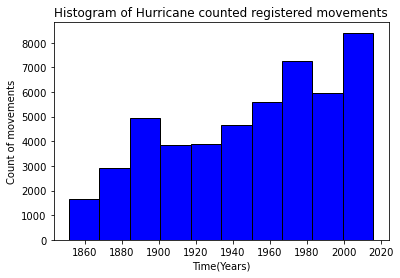

In [23]:
plt.hist(data['Timestamp'], color = 'blue', edgecolor = 'black')
# Labels
plt.title('Histogram of Hurricane counted registered movements')
plt.xlabel('Time(Years)')
plt.ylabel('Count of movements')

The increase of counted hurricane movements after throughout the decades is probably consequence of better and more reliable measurements, rather than the potential increase of hurricanes. Below, the number of registered movements in the dataset and total of hurricanes is shown.

In [24]:
#total number of movements and hurricanes registered in the dataset
ids = data.ID.values.tolist()
ids_dist = np.unique(ids)
print('Total number of hurricane movements: ', len(data.index))
print('Total number of hurricanes: ', len(np.unique(ids)))

Total number of hurricane movements:  49103
Total number of hurricanes:  1814


In [25]:
#summary statistics of the whole dataset
data.describe()

,Lat,Lon,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
count,49103.000000,49103.000000,49103.000000,18436.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000
mean,27.044229,-65.670597,52.997006,992.244250,81.865394,76.518325,48.647188,59.156393,24.641952,23.029894,15.427293,18.403141,8.110117,7.357710,5.130890,6.269211
std,10.077531,19.598589,24.671781,19.113748,88.097930,87.563153,75.209183,77.568911,41.592337,42.017821,32.105372,35.411258,19.792002,18.730334,14.033464,16.876623
min,7.200000,-109.500000,10.000000,882.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.100000,-81.000000,35.000000,984.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.400000,-68.000000,45.000000,999.000000,60.000000,60.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,33.100000,-52.500000,70.000000,1006.000000,130.000000,120.000000,75.000000,90.000000,40.000000,35.000000,20.000000,30.000000,0.000000,0.000000,0.000000,0.000000
max,81.000000,63.000000,165.000000,1024.000000,710.000000,600.000000,640.000000,530.000000,360.000000,300.000000,330.000000,360.000000,180.000000,250.000000,150.000000,180.000000


As observable in this summary statistics of the quantitative variables of the dataset, the -999 values are not taken into account due to the NaN handling. 

Regarding categorical variables, Status and Event can be the only ones identified (Name and ID are instance indentifiers).

In [26]:
#explore its categories
print('Event categories: ', data['Event'].unique())
print('Status categories: ', data['Status'].unique())

Event categories:  ['  ' ' L' ' R' ' I' ' P' ' W' ' C' ' S' ' G' ' T']
Status categories:  [' HU' ' TS' ' EX' ' TD' ' LO' ' DB' ' SD' ' SS' ' WV']


For description of each specific category, see the attached metadata document in this repository. 

Bounding box:  [-109.5    7.2   63.    81. ]


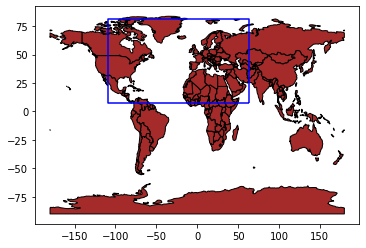

In [27]:
#Geographical bbox of the entire dataset
data_gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.Lon, data.Lat))
bbox = data_gdf.total_bounds
print('Bounding box: ', bbox)
#create bbox polygon & plot it using shapely
box_pol = box(*bbox)
gpd_box = gpd.GeoSeries(box_pol)
proj_bbox = gpd_box.set_crs(epsg=4326)
base = world.plot(color='brown', edgecolor='black')
proj_bbox.boundary.plot(ax=base, marker='x', color='blue', markersize=25);

As shown in this map, the dataset covers the atlantic ocean accordingly.

In [28]:
#check specific temporal timeline of the dataset
print('Starting date of the dataset: ', min(data['Timestamp']))
print('Last record of the dataset; ', max(data['Timestamp']))

Starting date of the dataset:  1851-06-25 00:00:00
Last record of the dataset;  2015-11-13 12:00:00


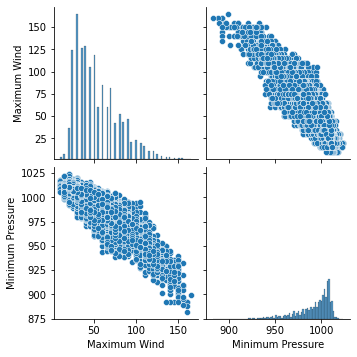

In [29]:
#correlation between Wind and Pressure
sns.pairplot(data,
    x_vars=["Maximum Wind", "Minimum Pressure"],
    y_vars=["Maximum Wind", "Minimum Pressure"],
)

To simplify the correlation plotting of variables and start approaching the prediction problem, wind and pressure have been selected since they will be relevant predictor variables. According to the plot and some basic metheorological principles, pressure and wind are always negatively correlated (lower the pressure the higher the wind). 

## 2. Feature Engineering

In this second section, the preparation of the data for feeding the subsequent prediction algorithms will be carried out. Therefore, predictor features will be defined and irrelevant columns will be ignored. The selected variables from the data are Maximum Wind and Minimum Pressure, since the low, moderate and high wind values are not as relevant for this prediction problem (they would be more relevant to predict position since they give orientation information) and there are only 5000 available records (from 2004 onwards). According to this, these variables wil be ignored and only ID, Timestamp, Lat & Lon, Max Wind and Min Pressure will be kept. From here, this section aims to calculate the feature to predict: speed.

In [30]:
#creating data frame for used for prediction
data_pred = data[['ID', 'Timestamp', 'Lat', 'Lon', 'Maximum Wind', 'Minimum Pressure']]
data_pred.head()

,ID,Timestamp,Lat,Lon,Maximum Wind,Minimum Pressure
0,AL011851,1851-06-25 00:00:00,28.0,-94.8,80.0,NaN
1,AL011851,1851-06-25 06:00:00,28.0,-95.4,80.0,NaN
2,AL011851,1851-06-25 12:00:00,28.0,-96.0,80.0,NaN
3,AL011851,1851-06-25 18:00:00,28.1,-96.5,80.0,NaN
4,AL011851,1851-06-25 21:00:00,28.2,-96.8,80.0,NaN


With the prediction dateset looking like this, the main feature to predict (speed) will be added and accordingly calculated. However, it is not as straightforward as it looks. First of all, a new feature regarding location (lat & lon merged) must be added in the dataframe. From here, the distance moved (within each measurement - 6h) will be calculated and therefore, a distance feature will be also added. Finally, speed will be able to be calculated by using the distance and time. 

In [31]:
x= data.Lon.values.tolist() #longitudes
y= data.Lat.values.tolist() #latitudes
location = []

for i in range(len(data)):
    loc1=(y[i], x[i])
    location.append(loc1)
    
data_pred = data_pred.copy() #to handle SettingwithCopy warning
data_pred['Location'] = location

In [32]:
data_pred.head()

,ID,Timestamp,Lat,Lon,Maximum Wind,Minimum Pressure,Location
0,AL011851,1851-06-25 00:00:00,28.0,-94.8,80.0,NaN,"(28.0, -94.8)"
1,AL011851,1851-06-25 06:00:00,28.0,-95.4,80.0,NaN,"(28.0, -95.4)"
2,AL011851,1851-06-25 12:00:00,28.0,-96.0,80.0,NaN,"(28.0, -96.0)"
3,AL011851,1851-06-25 18:00:00,28.1,-96.5,80.0,NaN,"(28.1, -96.5)"
4,AL011851,1851-06-25 21:00:00,28.2,-96.8,80.0,NaN,"(28.2, -96.8)"


Locations field has been calculated, now the two fields lat and lon can be removed from this prediction dataframe and proceed through the distance field calculation. In this calculation, the different hurricane ID's must be taken into account, so values are not mixed. 

In [33]:
#remove lat lon separate fields
del data_pred['Lat']
del data_pred['Lon']

#distance field calculation (km)
loc_lst = data_pred.Location.values.tolist()
id_lst = data_pred.ID.values.tolist()
distance = []

for i in range(len(data_pred)):
    if id_lst[i] == id_lst[i-1]: #if current id is the same as previous(same hurricane)
        try:
            loc1 = loc_lst[i-1]
            loc2 = loc_lst[i]
            dist = hs.haversine(loc1,loc2) #distance calculation in Km
            distance.append(dist)
        except:
            distance.append(np.nan)  
    else: 
        distance.append(np.nan)

data_pred['Distance_km'] = distance
data_pred.head()

,ID,Timestamp,Maximum Wind,Minimum Pressure,Location,Distance_km
0,AL011851,1851-06-25 00:00:00,80.0,NaN,"(28.0, -94.8)",NaN
1,AL011851,1851-06-25 06:00:00,80.0,NaN,"(28.0, -95.4)",58.907598
2,AL011851,1851-06-25 12:00:00,80.0,NaN,"(28.0, -96.0)",58.907598
3,AL011851,1851-06-25 18:00:00,80.0,NaN,"(28.1, -96.5)",50.311046
4,AL011851,1851-06-25 21:00:00,80.0,NaN,"(28.2, -96.8)",31.444414


Distance has been calculated using the haversine module (package to calculate distances between coordinates). Therefore, the speed feature (in km/h) can now be accordingly calculated.

In [34]:
#speed calculation
dists = data_pred.Distance_km.values.tolist()
speed = []

for i in range(len(data_pred)):
    if id_lst[i] == id_lst[i-1]: #if current id is the same as previous(same hurricane)
        try:
            speed_value = dists[i] / 6 #distance value divided by 6h -> speed in km/h
            speed.append(speed_value)
        except:
            speed.append(np.nan)  
    else: 
        speed.append(np.nan)

data_pred['Avg_Speed'] = speed
data_pred.head()

,ID,Timestamp,Maximum Wind,Minimum Pressure,Location,Distance_km,Avg_Speed
0,AL011851,1851-06-25 00:00:00,80.0,NaN,"(28.0, -94.8)",NaN,NaN
1,AL011851,1851-06-25 06:00:00,80.0,NaN,"(28.0, -95.4)",58.907598,9.817933
2,AL011851,1851-06-25 12:00:00,80.0,NaN,"(28.0, -96.0)",58.907598,9.817933
3,AL011851,1851-06-25 18:00:00,80.0,NaN,"(28.1, -96.5)",50.311046,8.385174
4,AL011851,1851-06-25 21:00:00,80.0,NaN,"(28.2, -96.8)",31.444414,5.240736


Location are distance are not relevant attributes anymore for the prediction dataframe, since they were created with the only aim of being able to calculate the speed of each registered movement.

In [35]:
#delete location & distance columns from prediction dataframe
del data_pred['Location']
del data_pred['Distance_km']

Having created and selected the main features for this prediction problem, it is time to check the correlation between features, in order to chose the appropiate subsequent machine learning techniques. For this, three different correlation methods will be used in order to truly check this property.

In [36]:
#checking data correlation
data_pred.corr(method='pearson')

,Maximum Wind,Minimum Pressure,Avg_Speed
Maximum Wind,1.000000,-0.925678,0.028818
Minimum Pressure,-0.925678,1.000000,-0.051641
Avg_Speed,0.028818,-0.051641,1.000000


In [37]:
data_pred.corr(method='kendall')

,Maximum Wind,Minimum Pressure,Avg_Speed
Maximum Wind,1.000000,-0.767965,0.038085
Minimum Pressure,-0.767965,1.000000,-0.040170
Avg_Speed,0.038085,-0.040170,1.000000


In [38]:
data_pred.corr(method='spearman')

,Maximum Wind,Minimum Pressure,Avg_Speed
Maximum Wind,1.000000,-0.903831,0.055782
Minimum Pressure,-0.903831,1.000000,-0.060497
Avg_Speed,0.055782,-0.060497,1.000000


In this case, the only significant correlation we find is the one between Maximum Wind and Minimum Pressure. However, for the feature to predict (speed), there is no significant correlated feature. According to this, a linear model cannot be used since it will fail due to the lack of correlated features. Therefore, the prediction problem (avg speed prediction in the next movement) will be tackled with <b> non-linear techniques </b>. 

Most of the ML algorightms and neural networks do not deal good with NaN values. In this case and as the last part of the feature engineering, this problem must be approached. It is basically present in two features: Minimum Pressure and Speed. <br> For Min Pressure, since it is highly negatively correlated with Maximum Wind and it has a bit more than 30 thousand NaN values, we can easily drop this attribute. Also, because it has no correlation with speed at all. <br>Regarding Speed, each first hurricane movement starts with a NaN speed. Therefore, the easiest and most practical way to deal with it (so the prediction methods do not get affected) is to delete the rows with null speed values (delete each first movement). By doing this, the algorithm will be able to fit a model and be trained accordingly.

In [39]:
#delete Min Pressure
del data_pred['Minimum Pressure']

In [40]:
#delete NaN values
data_pred = data_pred.dropna()
#renaming Maximum Wind, so it doesnt contain a white space
data_pred = data_pred.rename(columns={'Maximum Wind' : 'Max_Wind'})
data_pred.head()

,ID,Timestamp,Max_Wind,Avg_Speed
1,AL011851,1851-06-25 06:00:00,80.0,9.817933
2,AL011851,1851-06-25 12:00:00,80.0,9.817933
3,AL011851,1851-06-25 18:00:00,80.0,8.385174
4,AL011851,1851-06-25 21:00:00,80.0,5.240736
5,AL011851,1851-06-26 00:00:00,70.0,3.266553


## 3. Prediction: Average Speed of the next hurricane movement. 

Continuing with the workflow, this is the point in which the already prepared data must be feed into two Machine Learning techniques in order to solve the aforementioned prediction problem and assess and evaluate the performance between these models. According to this, a more traditional algorithm will be first used (SuperVectorRegressor) and a neural network approach will be afterwards implemented. 

### 3.1. Technique: Super Vector Regressor (SVR)

(algo explanation)

#### Normalize and Split data

In [41]:
#feature scaling
scalerx = preprocessing.MinMaxScaler()
scalery = preprocessing.MinMaxScaler()
X = scalerx.fit_transform(data_pred.Max_Wind.values.reshape(-1,1))
y = scalery.fit_transform(data_pred.Avg_Speed.values.reshape(-1,1))


Split data between training and testing data. In this case, 90% of the data will be for training and 10% for testing. 

In [42]:
#split between train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state=42)

Time to train the model.

In [43]:
#using a non linear kernel for the model
SVR_model = SVR(kernel='rbf') 
SVR_model.fit(X_train, y_train.ravel())

SVR()

Prediction comes now (using the test data).

In [44]:
y_pred = SVR_model.predict(X_test)
y_pred

array([0.14111852, 0.14067205, 0.13520767, ..., 0.13979415, 0.14111852,
       0.14213819])

Model evaluation

In [45]:
#using different evaluation indicators
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('Root mean squared error:',  rmse)
print('Mean absolute error:',  mae)

Root mean squared error: 0.076614495774063
Mean absolute error: 0.059468336057056176


In [46]:
r = scalery.inverse_transform(y_test.reshape(-1,1))
t = scalery.inverse_transform(y_pred.reshape(-1,1))
data_col = {'Speed_real' : r.flatten(), 'Speed_Predicted' : t.flatten()}


df_pred = pd.DataFrame(data_col)
df_pred

,Speed_real,Speed_Predicted
0,16.398964,26.126364
1,46.111425,26.043704
2,24.055913,25.032041
3,9.400729,22.583544
4,20.385765,25.032041
...,...,...
4724,7.639394,24.019891
4725,42.720713,25.568475
4726,10.870715,25.881172
4727,77.386289,26.126364


### 3.2. Neural Network Approach: Multi-Layer Perceptron

algo explanation - why chosen?

train NN regressor

https://www.machinecurve.com/index.php/2019/07/30/creating-an-mlp-for-regression-with-keras/
